In [73]:
import pdb
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import csv
from nltk.stem import WordNetLemmatizer
import wget
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
import pdb
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

# Data preprocessing and feature engineering

Download and read data from my github
The commented code with '#' need to be run for the first running of the code. They are downloading the relevant datasets or packages.

In [2]:
#wget.download('https://github.com/MarkIsDoingIt/STA2101/raw/main/datasets/mbti_text.csv')
df=pd.read_csv('mbti_text.csv')
target = df['type'].values
posts = df['posts'].values

Construct word cleaning list, including stopwords, punctuations and single numbers.
Select the posts without website url link, clean the redundant components, remove case sensitivity, implement word lemmatization.
Concat all posts for each person together in one string and build the whole corpus.

In [76]:
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('omw-1.4')
#nltk.download('wordnet')
#nltk.download('vader_lexicon')
numbers = [str(num) for num in range(0, 10)]
stop = set(stopwords.words('english') + list(string.punctuation) + ['--', '....', '..', '\'ll', '\'d', '...', 'n\'t', '\'s', '\'m', '\'ve', '\'re'] + numbers)

In [93]:
corpus = []
mbti = []
sentiment = []
coupus_file =open('result_data/corpus_clean.txt', "w", encoding="utf8", errors="surrogateescape")
ps =PorterStemmer()
wl = WordNetLemmatizer()
for i in tqdm(range(len(posts))):
    document = ''
    for post in posts[i].split('|||'):
        if 'http' not in post:
            cleaned_text = ' '.join([wl.lemmatize(word) for word in word_tokenize(post.lower()) if word not in stop])
            document = document + cleaned_text + ' '
    if document != '' and document != ' ':
        mbti.append(target[i])
        coupus_file.write(document)
        coupus_file.write("\n")
        corpus.append(document)
mbti = pd.DataFrame(data=mbti)
mbti.to_csv('result_data/mbti_target.csv', header = 0, index=None)

100%|██████████| 8675/8675 [00:59<00:00, 145.01it/s]


Next few steps to create the word frequency matrix and convert it to the form of simple triplet matrix,
which is a compatible data structure with R LDA function.

In [7]:
corpus_list = []
word_dict = {}
for line in corpus:
    corpus_list.extend(line.strip().split(' '))
for item in corpus_list:
    if item not in word_dict:
        word_dict[item] = 1
    else:
        word_dict[item] += 1
sorted_dict = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
wordCount_file = csv.writer(open("result_data/wordCount.csv", 'w', newline='', encoding='utf8'))
wordList_file = csv.writer(open("result_data/wordList.csv", 'w', newline='', encoding='utf8'))
i = 0
for key in sorted_dict:
    wordCount_file.writerow([i, key[0], key[1]])
    wordList_file.writerow([key[0]])
    i+=1

Now we get the file 'wordCount.csv', we can see what's the component of the corpus.
That's not the main part of the project, but can give us a better overview about the dataset.

In [23]:
word_list = pd.read_csv('result_data/wordList.csv',encoding='utf8', index_col=False, header=None)[0]
word_dict = {}
result_dict={}
countLine = 0;
num=0
for item in word_list:
    word_dict[item]=num
    num=num+1
for line in corpus:
    words = []
    words.extend(line.strip().split(' '))
    for word in words:
        if word in word_dict:
            if (countLine,word_dict[word]) not in result_dict:
                result_dict[(countLine,word_dict[word])]=1
            else:
                result_dict[(countLine,word_dict[word])]+=1
    countLine+=1

Now we get the sparse matrix of the word frequency matrix.
Our next step is convert it into the readable data structure for R.

In [24]:
print(len(result_dict))

3502965


3502965 = 2019 * 1735
While R reading txt or csv file, it prefers intact columns and rows, which means the txt file looks like rectangular.
So we write 2019 data in one line.

In [ ]:
perLine = 2019
i=open("result_data/i.txt", "w", errors="surrogateescape")
j=open("result_data/j.txt", "w", errors="surrogateescape")
v=open("result_data/v.txt", "w", errors="surrogateescape")
num=0
for key in result_dict:
    num+=1
    i.write(str(int(key[0])+1))
    i.write(' ')
    j.write(str(int(key[1])+1))
    j.write(' ')
    v.write(str(result_dict[key[0],key[1]]))
    v.write(' ')
    if num%perLine==0:
        i.write('\n')
        j.write('\n')
        v.write('\n')
i.close()
j.close()
v.close()

Now we finished the construction of simple triple matrix of word frequency matrix.
Then we will construct the table of sentiment score.

In [ ]:
for line in tqdm(corpus):
    sid = SentimentIntensityAnalyzer()
    ss = sid.polarity_scores(line)
    sentiment.append([ss['neg'], ss['pos']])
sentiment = pd.DataFrame(data = sentiment, columns=['neg', 'pos'])
sentiment.to_csv('result_data/sentiment.csv', header = None, index=None)

# After LDA by R
Our hyperparameter is setted to k = 10, which means our LDA will give the probability
of every  post relates to each of the ten topics.
After implementing LDA from R, we can use the following code to view the LDA topics.
We will see the top 20 words with highest probability for each topic, which is helpful
to have a better understanding about the corpus.

In [27]:
probMatrix_csv=pd.read_csv('result_data/topics_k10.csv',index_col=False)
np.save("result_data/probMatrix_k10.npy", probMatrix_csv)
probMatrix=np.load('result_data/probMatrix_k10.npy',allow_pickle=True)
top20_Matrix=np.zeros((20,10,2))
sorted_topics=np.zeros((10,np.shape(probMatrix)[0],np.shape(probMatrix)[1]))
for k in range(10):
    sorted_topics[k] = sorted(probMatrix, key = lambda x: x[k+1], reverse=True)
    for i in range(20):
        top20_Matrix[i, k, 0] = sorted_topics[k][i][0]
        top20_Matrix[i, k, 1] = np.exp(sorted_topics[k][i][k+1])

In [55]:
word_list=pd.read_csv('result_data/wordList.csv',encoding='utf8',header=None,index_col=False)[0].to_numpy()
outfile = open("result_data/top20_words_k10.txt", "w", encoding="utf8", errors="surrogateescape")
for i in range(10):
    outfile.write('Topic ')
    outfile.write(str(i+1))
    outfile.write('\n')
    for j in range(20):
        outfile.write(str(j+1))
        outfile.write('  ')
        outfile.write(str(word_list[int(top20_Matrix[j,i,0]-1)]))
        outfile.write('  ')
        outfile.write(str(top20_Matrix[j,i,1]))
        outfile.write('\n')
    outfile.write('\n')
outfile.close()

# Plots and showcase
The rest part of this jupyter notebook does not have contribution to the main part of this model.
They are some plots and brief presentation showed in the paper.

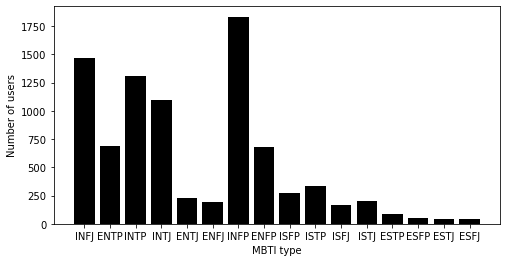

In [107]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
dict = {}
for item in target:
    dict[item] = dict.get(item, 0) + 1
plt.bar(list(dict.keys()), dict.values(), color='black')
plt.ylabel('Number of users')
plt.xlabel('MBTI type')
plt.savefig('result_data/distribution of MBTI')
plt.show()

In [106]:
i = 20
for post in posts[i].split('|||'):
    if 'http' not in post:
        cleaned_text = ' '.join([wl.lemmatize(word) for word in word_tokenize(post.lower()) if word not in stop])
        print(cleaned_text)
        print(post)
        break

'steve job recognized striving efficiency practicality genius systemization invention le invention claim se te come
'Steve Job's was recognized for his striving for efficiency and practicality. His genius is in his systemization of inventions, less so than in invention. This is where claims of Se and Te come from.
